## Imports

In [164]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [177]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
    
    row, col = u.shape
    ctx = c*dt/dx
    cty = c*dt/dy
    for it in range(nt):
        #for i in range(nx): un[i] = u[i]
        for j in range(1, row-1):
            for i in range(1, col-1):
                u[j, i] = u[j, i] - ctx*(u[j, i] - u[j, i-1]) -cty*(u[j, i] - u[j-1, i])
        u[0, :] = 1
        u[ny-1, :] = 1
        u[:, 0] = 1
        u[:, nx-1] = 1
    return 0

## Numba accelerator

In [178]:
@njit(fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):    
    row, col = u.shape
    ctx = c*dt/dx
    cty = c*dt/dy
    for it in range(nt):
        for i in range(nx): un[i] = u[i]
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = u[j-1, i-1] - ctx*(u[j-1, i-1] - u[j-1, i-2]) -cty*(u[j-1, i-1] - u[j-2, i-1])
        u[0, :] = 1
        u[ny-1, :] = 1
        u[:, 0] = 1
        u[:, nx-1] = 1
    return 0

## Pyccel accelerator

In [189]:
@types('float[:,:]', 'float[:,:]', 'int', 'float', 'float','float', 'float')
def solve_2d_linearconv_pyccel(u, un, nt, dt, dx, dy, c):
    row, col = u.shape
    ctx = c*dt/dx
    cty = c*dt/dy
    for it in range(nt):
        #for i in range(nx): un[i] = u[i]
        for j in range(1, row-1):
            for i in range(1, col-1):
                u[j, i] = u[j, i] -(u[j, i] + u[j, i-1]) * ctx -(u[j, i] + u[j-1, i]) * cty
        u[0, :] = 1
        u[row-1, :] = 1
        u[:, 0] = 1
        u[:, col-1] = 1
               
    return 0

## Inputs

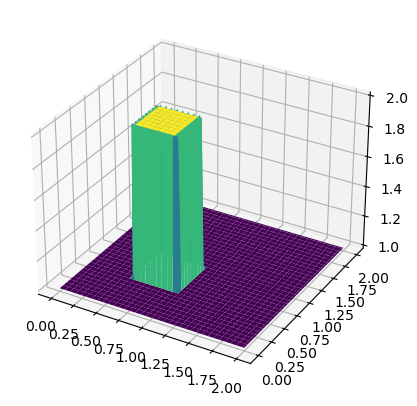

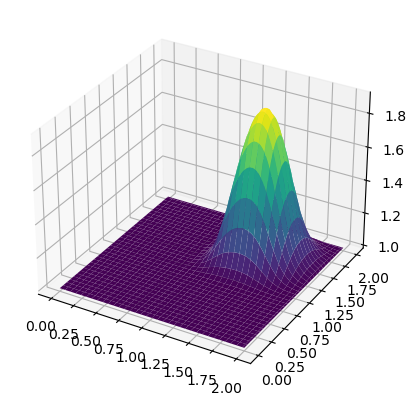

In [190]:
###variable declarations
nx = 101
ny = 101
nt = 100
c = 1.0
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx))

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [191]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

1.5 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [192]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

6.78 ms ± 4.08 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Function with pyccel accelerator

In [193]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel)

In [194]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

6.16 ms ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
